# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


# Configuration & Reproducibility

In [2]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Pivot Dataset

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
df = df.pivot_table(index="image_path", columns="target_name", values="target").reset_index()
df.fillna(0, inplace=True)

TARGET_COLUMNS = ['Dry_Green_g','Dry_Dead_g','Dry_Clover_g','GDM_g','Dry_Total_g']
print("Dataset shape:", df.shape)


Dataset shape: (357, 6)


#  Train / Validation Split & Scaling

In [4]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
scaler = StandardScaler()
scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Class & DataLoaders

In [5]:
class BiomassDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, scaler=None):
        self.df = df.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        img = Image.open(os.path.join(self.image_dir, row.image_path)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = np.array([getattr(row, t) for t in TARGET_COLUMNS], dtype=np.float32)
        if self.scaler:
            target = self.scaler.transform(target.reshape(1,-1))[0]
        return img, torch.tensor(target)


In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# Weighted Loss & Metric

In [7]:
TARGET_WEIGHTS = torch.tensor([0.1,0.1,0.1,0.2,0.5], device=DEVICE)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)
    def forward(self, preds, targets):
        return ((preds-targets)**2 * self.weights).mean()

criterion = WeightedMSELoss(TARGET_WEIGHTS)

def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred)**2).sum(0)
    ss_tot = ((y_true - mean_y)**2).sum(0)
    return (1 - (weights*ss_res).sum() / ((weights*ss_tot).sum()+1e-8)).item()


# CNN Architecture With Dropout

In [8]:
class CNNWithDropout(nn.Module):
    def __init__(self, num_filters=256, num_blocks=3, dropout=0.0, num_outputs=5):
        super().__init__()
        layers = []
        in_channels = 3

        for _ in range(num_blocks):
            layers += [
                nn.Conv2d(in_channels, num_filters, 3, padding=1),
                nn.BatchNorm2d(num_filters),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout)
            ]
            in_channels = num_filters

        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.regressor = nn.Linear(num_filters, num_outputs)

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


# One-Epoch Train / Eval Function

In [9]:
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total_r2, n = 0, 0, 0
    with torch.set_grad_enabled(training):
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            preds = model(imgs)
            loss = criterion(preds, targets)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            b = imgs.size(0)
            total_loss += loss.item()*b
            total_r2 += weighted_r2_score(targets, preds, TARGET_WEIGHTS)*b
            n += b
    return total_loss/n, total_r2/n


# Experiment Setup – Dropout & Weight Decay Grid

In [10]:
dropout_options = [0.0, 0.2, 0.4, 0.6]
weight_decay_options = [0.0, 1e-4, 1e-3]

results = {}


# Training Loop Across Grid

In [11]:
for dropout in dropout_options:
    for wd in weight_decay_options:
        key = f"dropout_{dropout}_wd_{wd}"
        print(f"\n==============================")
        print(f" Training: {key}")
        print(f"==============================")

        train_dataset = BiomassDataset(train_df, os.path.join(BASE_PATH,"train"), transform, scaler)
        val_dataset = BiomassDataset(val_df, os.path.join(BASE_PATH,"train"), transform, scaler)

        train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=2)

        model = CNNWithDropout(dropout=dropout).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=wd)

        train_losses, val_losses = [], []
        train_r2s, val_r2s = [], []
        best_val_r2 = -1e9

        for epoch in range(NUM_EPOCHS):
            tr_l, tr_r2 = run_epoch(model, train_loader, optimizer)
            va_l, va_r2 = run_epoch(model, val_loader)

            train_losses.append(tr_l)
            val_losses.append(va_l)
            train_r2s.append(tr_r2)
            val_r2s.append(va_r2)

            best_val_r2 = max(best_val_r2, va_r2)

            print(f"Epoch {epoch+1} | Train R²: {tr_r2:.4f} | Val R²: {va_r2:.4f}")

        results[key] = {
            "avg_train_r2": np.mean(train_r2s),
            "avg_val_r2": np.mean(val_r2s),
            "best_val_r2": best_val_r2,
            "avg_val_loss": np.mean(val_losses),
            "val_r2s": val_r2s
        }



 Training: dropout_0.0_wd_0.0
Epoch 1 | Train R²: -0.1828 | Val R²: -2.8919
Epoch 2 | Train R²: 0.0664 | Val R²: -0.0347
Epoch 3 | Train R²: 0.1575 | Val R²: 0.0125
Epoch 4 | Train R²: 0.1793 | Val R²: -0.1400
Epoch 5 | Train R²: 0.1811 | Val R²: 0.0934
Epoch 6 | Train R²: 0.0074 | Val R²: 0.0233
Epoch 7 | Train R²: 0.2040 | Val R²: 0.2315
Epoch 8 | Train R²: 0.1569 | Val R²: 0.1580
Epoch 9 | Train R²: 0.2087 | Val R²: 0.0561
Epoch 10 | Train R²: 0.1859 | Val R²: 0.0485
Epoch 11 | Train R²: 0.2280 | Val R²: -0.1283
Epoch 12 | Train R²: 0.1222 | Val R²: 0.0917
Epoch 13 | Train R²: 0.3197 | Val R²: 0.2016
Epoch 14 | Train R²: 0.2769 | Val R²: -0.7384
Epoch 15 | Train R²: 0.1959 | Val R²: -0.1416
Epoch 16 | Train R²: 0.2922 | Val R²: 0.1280
Epoch 17 | Train R²: 0.2755 | Val R²: 0.1336
Epoch 18 | Train R²: 0.2298 | Val R²: 0.2124
Epoch 19 | Train R²: 0.2706 | Val R²: 0.0161
Epoch 20 | Train R²: 0.2796 | Val R²: 0.2443

 Training: dropout_0.0_wd_0.0001
Epoch 1 | Train R²: -0.4445 | Val R²:

# Summary Table

In [12]:
summary_df = pd.DataFrame([
    {
        "Config": k,
        "Avg Val R²": results[k]["avg_val_r2"],
        "Best Val R²": results[k]["best_val_r2"],
        "Avg Val Loss": results[k]["avg_val_loss"]
    }
    for k in results
]).sort_values("Avg Val R²", ascending=False)

display(summary_df)


,Config,Avg Val R²,Best Val R²,Avg Val Loss
10,dropout_0.6_wd_0.0001,0.036435,0.192588,0.125264
9,dropout_0.6_wd_0.0,0.028142,0.260552,0.127469
1,dropout_0.0_wd_0.0001,0.020124,0.260305,0.127786
4,dropout_0.2_wd_0.0001,0.002020,0.272927,0.128306
11,dropout_0.6_wd_0.001,-0.005603,0.242948,0.131975
6,dropout_0.4_wd_0.0,-0.017695,0.235882,0.132386
5,dropout_0.2_wd_0.001,-0.021093,0.192886,0.133282
8,dropout_0.4_wd_0.001,-0.026578,0.178534,0.133049
2,dropout_0.0_wd_0.001,-0.031743,0.307861,0.136458
7,dropout_0.4_wd_0.0001,-0.074824,0.182548,0.139986


# Validation R² Curves

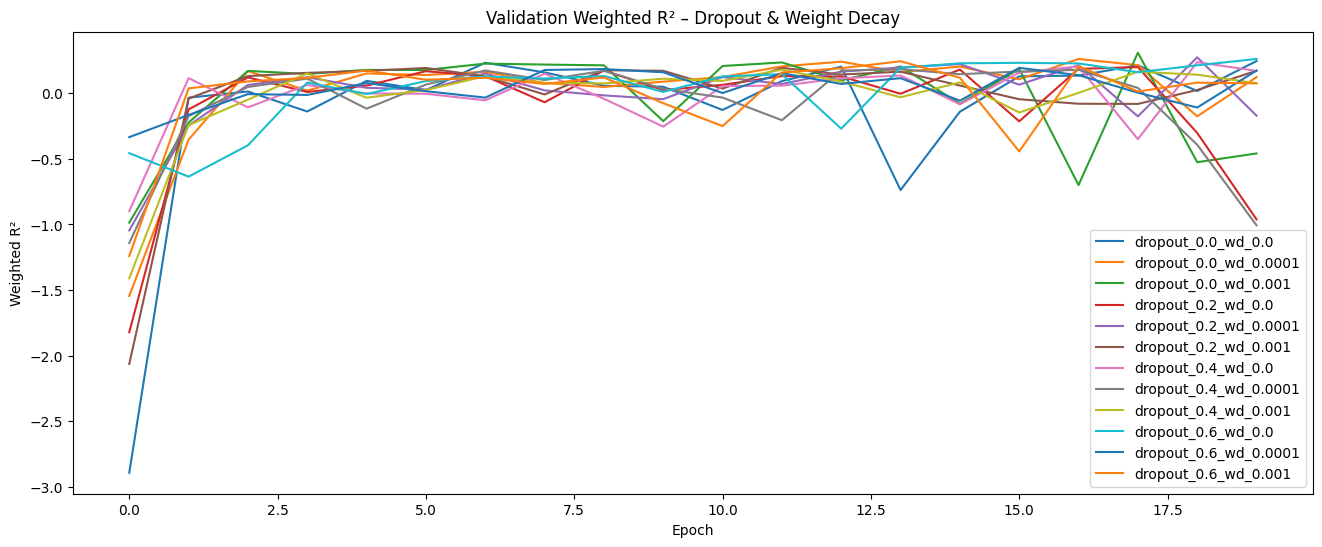

In [13]:
plt.figure(figsize=(16,6))
for k in results:
    plt.plot(results[k]["val_r2s"], label=k)
plt.title("Validation Weighted R² – Dropout & Weight Decay")
plt.xlabel("Epoch")
plt.ylabel("Weighted R²")
plt.legend()
plt.show()
